In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cupy as cp
import mne
import seaborn as sns
import cupyx.scipy.signal as sg
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [58]:
## Reading training and testing csv files
train_df = pd.read_csv(f'train.csv')[:200]
test_df = pd.read_csv(f'test.csv')

## Parquet File Names
train_df['eeg_path'] = f'train_eegs/'+train_df['eeg_id'].astype(str)+'.parquet'
train_df['spec_path'] = f'train_spectrograms/'+train_df['spectrogram_id'].astype(str)+'.parquet'

test_df['eeg_path'] = f'test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'

unique_eeg_ids = train_df['eeg_id'].unique()
unique_spec_ids = train_df['spectrogram_id'].unique()

In [59]:
train_eegs = dict()
train_df['eeg'] = ""

for i in unique_eeg_ids:
    fn = f'train_eegs/'+i.astype(str)+'.parquet'
    train_eegs[i] = pd.read_parquet(fn)

eeg_channel_names = train_eegs[train_df['eeg_id'][0]].columns
NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]
FEATS_idx = np.array([[eeg_channel_names.get_loc(i) for i in j] for j in FEATS])

In [60]:
train_specs = dict()
train_df['spec'] = ""

for i in unique_spec_ids:
   fn = f'train_spectrograms/'+i.astype(str)+'.parquet'
   train_specs[i] = pd.read_parquet(fn)
spec_channel_names = train_specs[train_df['spectrogram_id'][0]].columns

In [61]:
spec = train_specs[train_df['spectrogram_id'][0]]
spec

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,4.26,10.98,9.05,13.65,11.49,8.930000,18.840000,19.26,19.240000,...,0.31,0.17,0.28,0.19,0.24,0.27,0.29,0.16,0.22,0.19
1,3,2.65,3.97,12.18,13.26,14.21,13.230000,9.650000,8.11,11.280000,...,0.15,0.13,0.14,0.24,0.24,0.36,0.35,0.31,0.36,0.40
2,5,4.18,4.53,8.77,14.26,13.36,16.559999,19.219999,17.51,22.650000,...,0.29,0.21,0.16,0.25,0.28,0.28,0.34,0.48,0.44,0.48
3,7,2.41,3.21,4.92,8.07,5.97,12.420000,10.820000,14.96,21.809999,...,0.33,0.51,0.49,0.64,0.58,0.42,0.32,0.31,0.32,0.33
4,9,2.29,2.44,2.77,4.62,5.39,7.080000,9.840000,12.27,14.410000,...,0.44,0.38,0.48,0.63,0.45,0.45,0.49,0.33,0.31,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,631,6.36,6.59,6.60,7.30,4.48,8.400000,13.420000,13.85,16.010000,...,0.14,0.05,0.06,0.04,0.04,0.04,0.05,0.05,0.08,0.11
316,633,4.90,8.80,8.22,5.83,10.21,10.580000,10.250000,13.68,19.549999,...,0.16,0.08,0.06,0.06,0.07,0.04,0.06,0.09,0.07,0.08
317,635,6.07,7.85,11.26,9.20,8.18,9.130000,10.450000,15.09,23.020000,...,0.15,0.13,0.13,0.13,0.10,0.08,0.07,0.09,0.17,0.12
318,637,3.41,3.75,4.80,6.45,6.70,7.960000,8.160000,6.97,9.700000,...,0.13,0.11,0.13,0.07,0.11,0.12,0.09,0.16,0.19,0.19


In [62]:
def get_eeg_data_slice(i, train_df, train_eegs):
    start = (train_df['eeg_label_offset_seconds'][i]*200).astype(int)
    end = start + 200*50
    return train_eegs[train_df['eeg_id'][i]].iloc[start:end].to_numpy()

In [63]:
train_df['eeg'] = ""
print("Spliting EEG data")
with ThreadPoolExecutor() as executor:
    train_df['eeg'] = list(executor.map(get_eeg_data_slice, range(len(train_df)), [train_df]*len(train_df), [train_eegs]*len(train_df)))
train_final_data = train_df['eeg']
train_final_data = np.stack(train_final_data)

Spliting EEG data


In [64]:
train_final_data.shape

(200, 10000, 20)

In [65]:
def gpu_fft(data):
    """
    Perform GPU-accelerated Fast Fourier Transform (FFT) on the input data.

    Parameters:
    - data: numpy.ndarray
        The input data for FFT.

    Returns:
    - f: numpy.ndarray
        The frequency values.
    - t: numpy.ndarray
        The time values.
    - stft: numpy.ndarray
        The Short-Time Fourier Transform (STFT) of the input data.
    """
    f_s = 200
    l_s = 7
    data = cp.asarray(data)
    f, t, stft = sg.spectrogram(data, fs=f_s, nperseg=f_s*l_s, noverlap=f_s*l_s//1.03, window='boxcar', return_onesided=True, axis=1, mode='phase')
    return f.get(), t.get(), cp.moveaxis(stft, 1, -1).get()
    

In [75]:
# for i in np.arange(0, train_df.shape[0], 100):
#     dat_100 = train_final_data[i:i+100] #(100, fftax, chns=20)
def make_phase(dat_100):
    """
    Compute the phase spectrogram of the input data.

    Parameters:
    - dat_100 (ndarray): Input data in 100 batches of shape (100, fftax, chns=20).
    - l_s (int): Length of each fft segment in seconds.

    Returns:
    - f (ndarray): Array of frequencies.
    - t (ndarray): Array of time points.
    - phase (ndarray): Phase spectrogram of shape (100, chns=4, t, f).
    """
    f_s = 200
    l_s = 7
    dat_100 = cp.asarray(dat_100)
    dat_100 = np.stack((dat_100[:,:,FEATS_idx[:,0]] - dat_100[:,:,FEATS_idx[:,1]],
                        dat_100[:,:,FEATS_idx[:,1]] - dat_100[:,:,FEATS_idx[:,2]],
                        dat_100[:,:,FEATS_idx[:,2]] - dat_100[:,:,FEATS_idx[:,3]],
                        dat_100[:,:,FEATS_idx[:,3]] - dat_100[:,:,FEATS_idx[:,4]]),axis=-1) #(100, fftax, chns=4, to_concat)
    f, t, phase = sg.spectrogram(dat_100, fs=f_s, nperseg=f_s*l_s, noverlap=f_s*l_s//1.05, window='boxcar', return_onesided=True, axis=1, mode='phase')
    phase = cp.moveaxis(phase, 1, -1).sum(axis=2) / 4 #(100, chns=4, t, f)
    return f.get(), t.get(), phase.get()

In [67]:
# def main():
#     train_df = pd.read_csv(f'train.csv')
#     E_X = 0
#     E_Xsq = 0
#     for n in np.arange(0, train_df.shape[0], 100):
#         dat_100 = train_final_data[i:i+100]
#         _, _, phase = make_phase(dat_100)
#         E_X = (E_X * i/100 + phase.mean()) / (i/100 + 1)
#         E_Xsq = (E_Xsq * i/100 + (phase**2).mean()) / (i/100 + 1)
#         np.save(PATH'.npy', phase)
#     var = E_Xsq - E_X**2
#     for n in np.arange(0, train_df.shape[0], 100):
#         dat_100 = np.load(PATH'.npy')
#         dat_100 = (dat_100 - E_X) / np.sqrt(var)
#         np.save(PATH'.npy', dat_100)

In [79]:
phase.shape

(10, 4, 129, 701)

(129, 701)


AttributeError: 'Axes' object has no attribute 'inv'

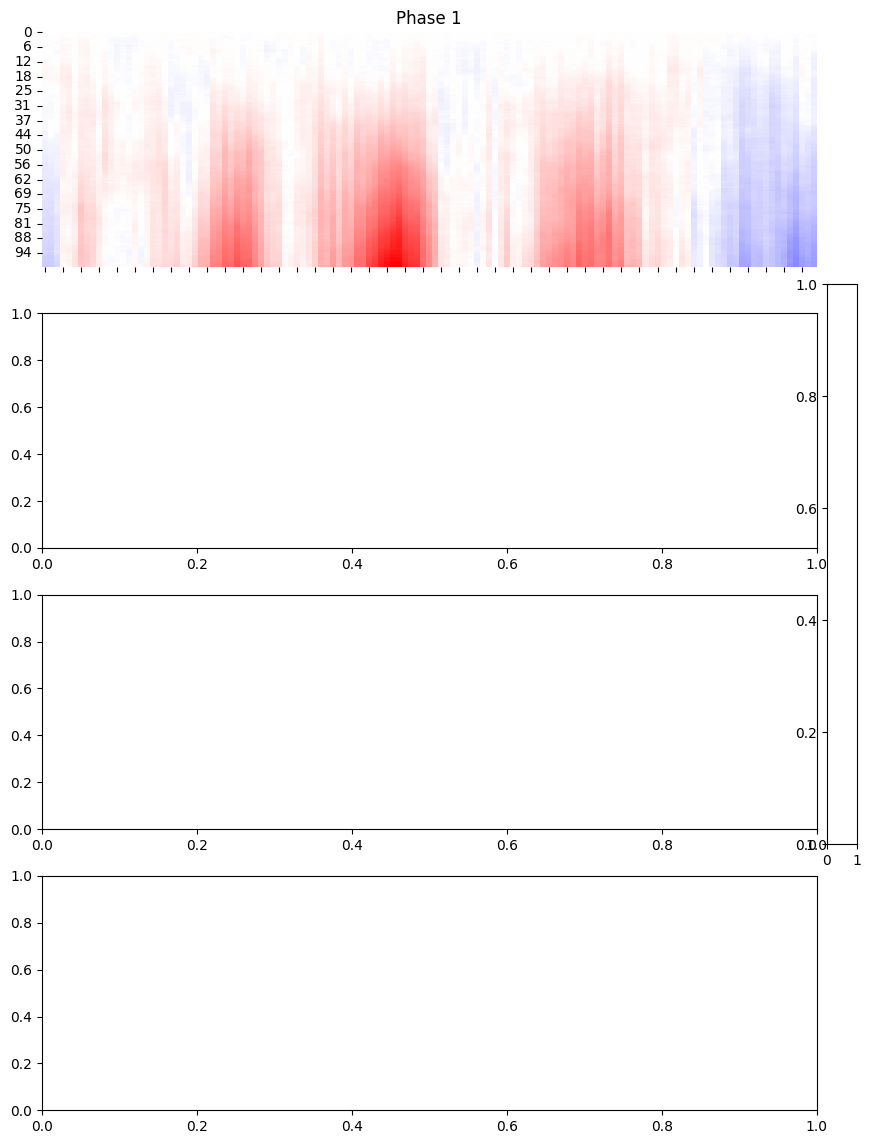

In [93]:
f, t, phase = make_phase(train_final_data[:10])
print(phase[0,0,:,:].shape)
fig, axes = plt.subplots(4, 1, figsize=(10, 14))  # 4 rows, 1 column for vertical stacking
cbar_ax = fig.add_axes([.91, .3, .03, .4])  # Position for the colorbar

for i in range(4):
    ax = axes[i]
    ax.set_title(f'Phase {i+1}')
    if i < 3:  # Hide x labels for all but the bottom plot
        ax.set_xlabel('')
        ax.tick_params(labelbottom=False)
    else:
        ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    phase_df = pd.DataFrame(phase[3, i, :, :].T, columns=t.astype(int), index=f.astype(int))
    sns.heatmap(phase_df, cmap='bwr', cbar=i == 3, cbar_ax=None if i < 3 else cbar_ax, center=0, ax=ax)
    ax.inv
plt.tight_layout(rect=[0, 0, .9, 1])  # Adjust the rect to fit the colorbar
plt.show()
